<a href="https://colab.research.google.com/github/tcaba2/Astroinformatics2024/blob/main/Week%205/Copia_de_Tutorial_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning tutorial

```Author: Paula Sánchez-Sáez, Last updated: 20241022```

In this notebook you will find examples on how to use [Keras](https://keras.io/getting_started/) + [TensorFlow 2.0](https://www.tensorflow.org) to implement DL architectures.
The notebook has four sections. Try to advance as much as you can during this laboratory. If you have time, try implementing your own version of the architectures presented here.

Notes:
- Some examples are adapted from the book [Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow](https://github.com/ageron/handson-ml3) and from the DL tutorial presented durint the [XXX Canary Islands Winter School of Astrophysic](http://research.iac.es/winterschool/2018/).
- Part of the notebook is taken from previous years of the LSDS (by Matthew Graham, Dmitry Duev, Ashish Mahabal, and Mauricio Cerda)
- You'll need to enable GPUs for the notebook:

  - Navigate to Edit→Notebook Settings
  - select GPU from the Hardware Accelerator drop-down

Let's see the hardware settings:

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Nov 21 07:49:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Table of contents:

* [Introduction](#intro)
* [Requirements](#req)
* [Basic NN](#nn)
* [Basic CNN](#cnn)
* [CNN for morphological classification of SDSS galaxies](#cnn_class)
* [RNN for time series analysis](#rnn)
* [Autoencoders](#ae)

## Introduction <a class="anchor" id="intro"></a>

The notebook is composed of five parts. The first section provides a simple NN model to classify images. In the second section, you will learn how to use CNNs to convolve images. In the third section how to use CNNs for morphological classification of galaxies. In the fourth section, you will model time series using RNN. Finally, in the fifth section, you will use RAEs for anomaly detection.

The idea of this notebook is to show some examples of architectures, but you can modify them as you wish and create your own architectures.




# Requirements <a class="anchor" id="req"></a>

In [2]:

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


Basic requirements

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, precision_recall_curve, accuracy_score, confusion_matrix
import random
import itertools



%matplotlib inline

Import TensorFlow and Keras:



In [4]:
import tensorflow as tf
print(tf.__version__) #to make sure we are using TF2.0

2.17.1


In [5]:
import tensorflow.keras as keras

from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.layers import SimpleRNN, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator



# Basic NN <a class="anchor" id="*nn*"></a>

In this section we will create a simple NN to classify images. Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in tf.keras.datasets. The dataset is already split for you between a training set (60,000 images) and a test set (10,000 images), but it can be useful to split the training set further to have a validation set. We'll use 55,000 images for training, and 5,000 for validation.

In [6]:
fashion_mnist = fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
X_train.shape

(55000, 28, 28)

Let's split the data into training, validation, and testing sets

In [8]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

Let's define the labels of the data and plot some examples

In [9]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

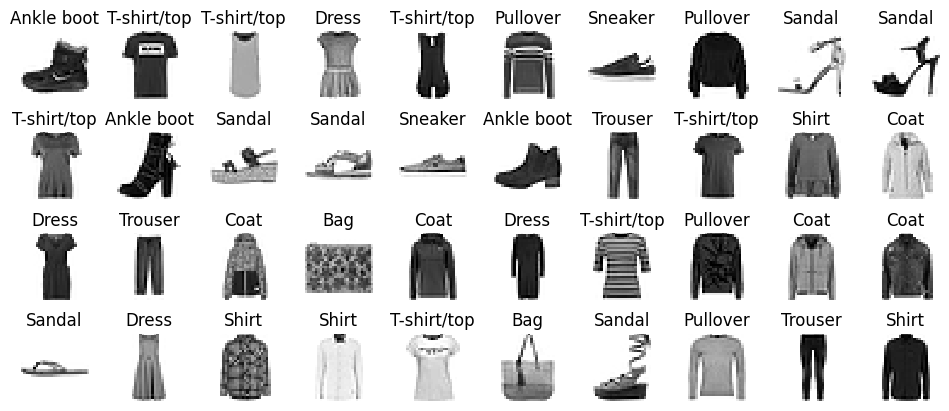

In [10]:
# extra code – this cell generates and saves Figure 10–10

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

Now we will create a NN or MLP model using the Keras Sequential API

In [11]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Let's visualize the model

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 300)                 │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

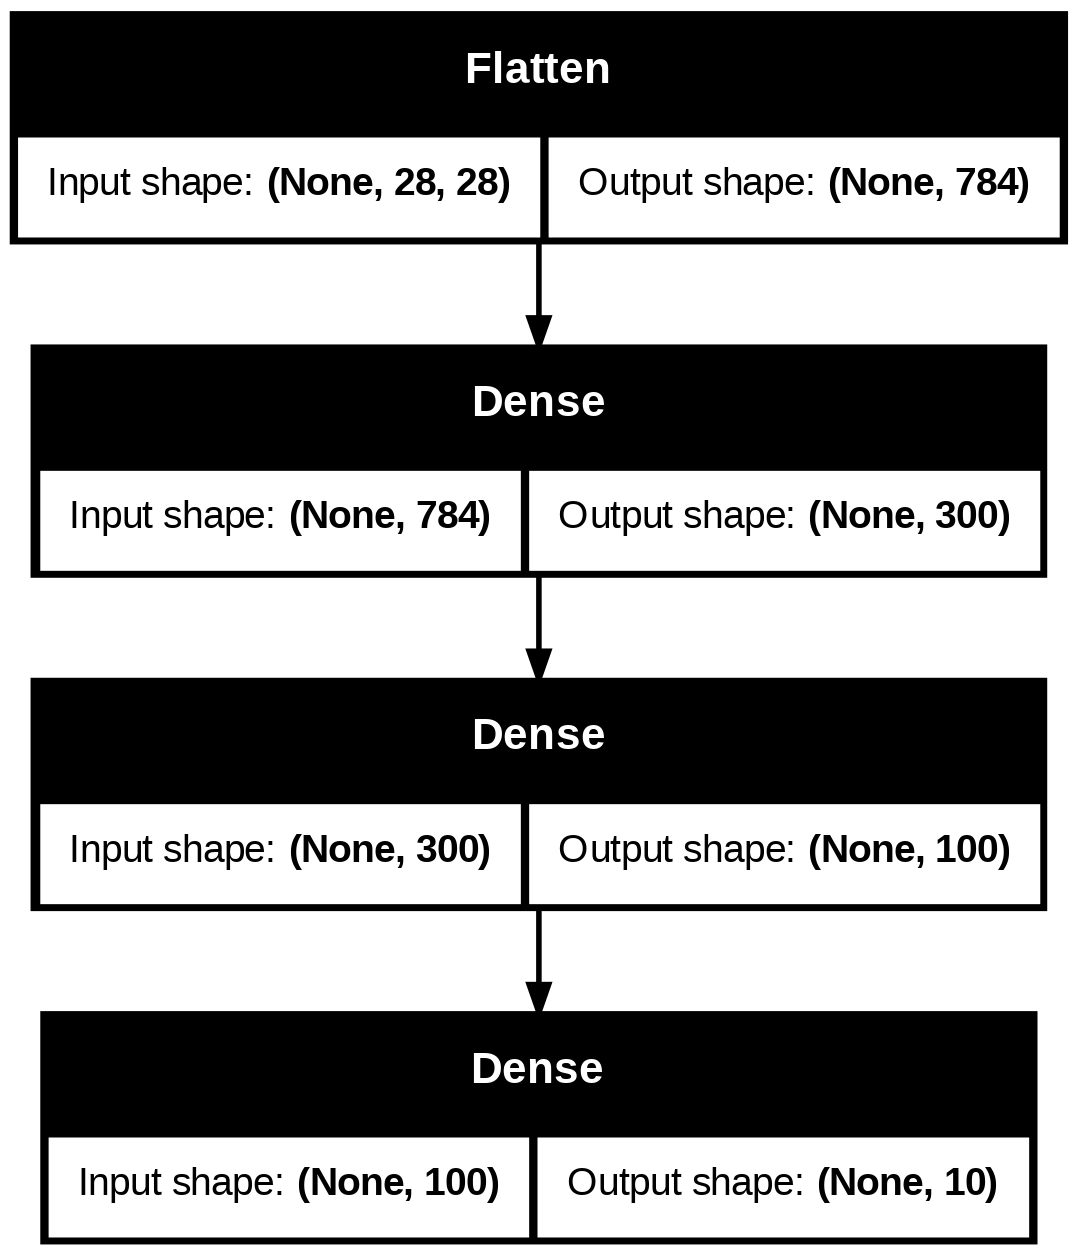

In [13]:
tf.keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

No we compile the model

In [14]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

And now we train the model. We will use early stopping to stop training when the val_loss and the train_loss are at their minimum.

In [15]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)



history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])

Epoch 1/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6693 - loss: 1.0429 - val_accuracy: 0.8262 - val_loss: 0.5129
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8255 - loss: 0.5086 - val_accuracy: 0.8370 - val_loss: 0.4607
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8419 - loss: 0.4550 - val_accuracy: 0.8474 - val_loss: 0.4344
Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8509 - loss: 0.4248 - val_accuracy: 0.8508 - val_loss: 0.4189
Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8586 - loss: 0.4033 - val_accuracy: 0.8548 - val_loss: 0.4077
Epoch 6/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8652 - loss: 0.3861 - val_accuracy: 0.8566 - val_loss: 0.4009
Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8697 - loss: 0.3718 - val_accuracy: 0.8594 - val_loss: 0.3922
Epoch 8/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8736 - loss: 0

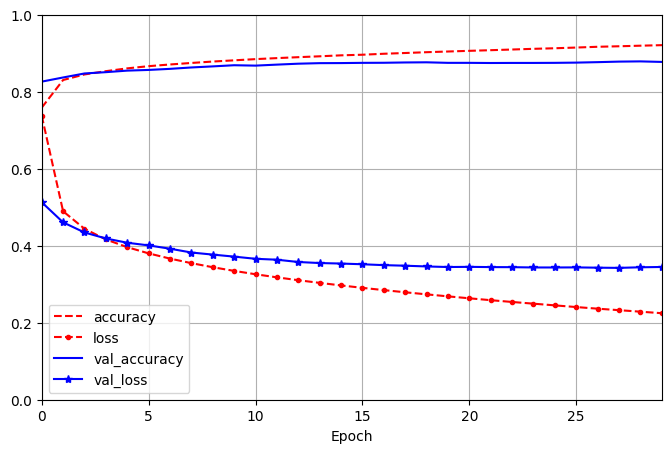

In [16]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
plt.show()

Now let's use the model to make predictions. First we predict some images from the testing set, and then we visualize the results.



In [17]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.16, 0.  , 0.  , 0.  , 0.83],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [18]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([9, 2, 1])

In [19]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

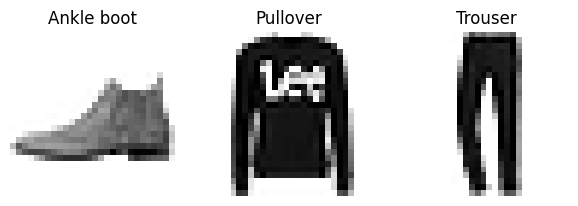

In [20]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# Basic CNN <a class="anchor" id="cnn"></a>

### What is a convolution?

In this sesction we will play with different filters to convolve images. You can upload your own image if you want.

(427, 640, 3)
(1, 427, 640, 3)


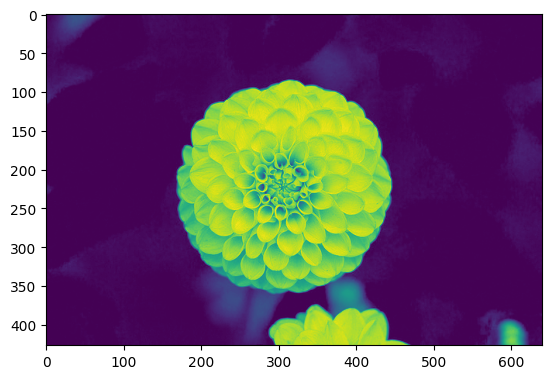

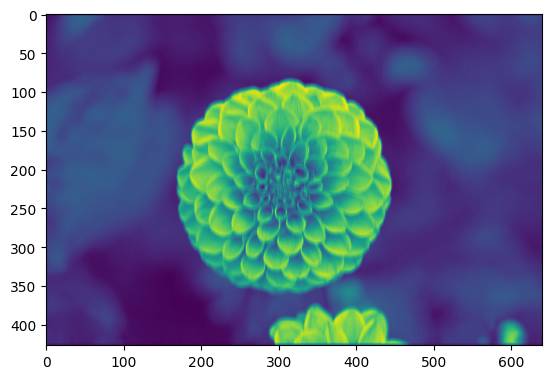

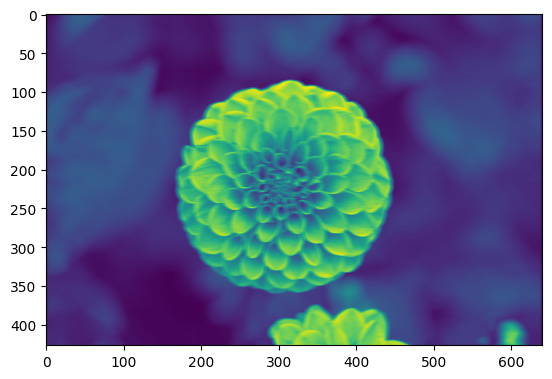

In [21]:
# Load sample images
image = load_sample_image("flower.jpg") / 255
print(image.shape)
image_batch = np.array([image])#Keras expects batches of images, so we have to add a dimension to trick it into being nice
print(image_batch.shape)
batch_size, height, width, channels = image_batch.shape

plt.imshow(image_batch[0, :, :, 0]) # plot original image
plt.show()

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(image_batch, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 0]) # plot image's 1st feature map
plt.show()

plt.imshow(outputs[0, :, :, 1]) # plot image's 2nd feature map
plt.show()

Notice any difference between the plots?

Define your own filters and see what happens:

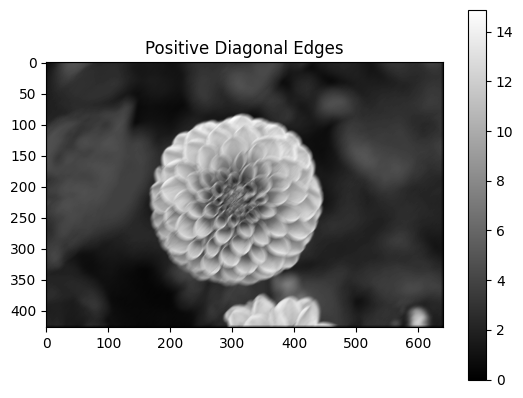

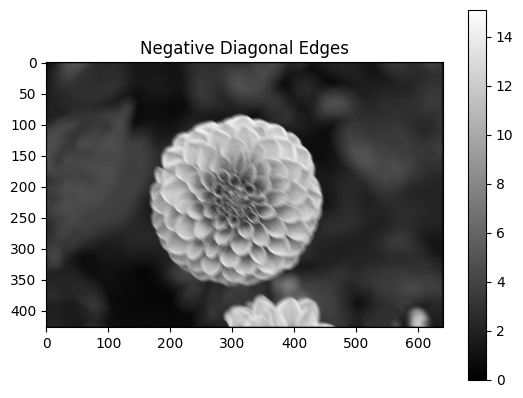

In [22]:
# Create your own filters here:
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)

# Define a 7x7 diagonal edge filter (positive slope) for all channels
positive_diagonal = [[0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 1],
                     [0, 0, 0, 0, 0, 1, 0],
                     [0, 0, 0, 0, 1, 0, 0],
                     [0, 0, 0, 1, 0, 0, 0],
                     [0, 0, 1, 0, 0, 0, 0],
                     [0, 1, 0, 0, 0, 0, 0]]

# Expand the filter for all channels
filters[:, :, :, 0] = np.stack([positive_diagonal] * channels, axis=-1)

# Define a 7x7 diagonal edge filter (negative slope) for all channels
negative_diagonal = [[0, 1, 0, 0, 0, 0, 0],
                     [0, 0, 1, 0, 0, 0, 0],
                     [0, 0, 0, 1, 0, 0, 0],
                     [0, 0, 0, 0, 1, 0, 0],
                     [0, 0, 0, 0, 0, 1, 0],
                     [0, 0, 0, 0, 0, 0, 1],
                     [0, 0, 0, 0, 0, 0, 0]]

# Expand the filter for all channels
filters[:, :, :, 1] = np.stack([negative_diagonal] * channels, axis=-1)

# Apply the filters
outputs = tf.nn.conv2d(image_batch, filters, strides=1, padding="SAME")

# Visualize the outputs
plt.imshow(outputs[0, :, :, 0], cmap='gray')  # Plot image's 1st feature map (positive slope edges)
plt.title("Positive Diagonal Edges")
plt.colorbar()
plt.show()

plt.imshow(outputs[0, :, :, 1], cmap='gray')  # Plot image's 2nd feature map (negative slope edges)
plt.title("Negative Diagonal Edges")
plt.colorbar()
plt.show()

### Lets create a model with 1 Convolutional layer

In [23]:
# function to deal with batches of one image
# Keras expects batches of images, so we have to add a dimension to trick it into being nice

def nice_image_printer(model, image):
    '''prints the cat as a 2d array'''
    image_batch = np.expand_dims(image,axis=0)
    conv_image2 = model.predict(image_batch)
    print(conv_image2.shape)

    conv_image2 = np.squeeze(conv_image2, axis=0)
    print(conv_image2.shape)
    conv_image2 = conv_image2.reshape(conv_image2.shape[:2])

    print(conv_image2.shape)
    plt.imshow(conv_image2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
(1, 425, 638, 1)
(425, 638, 1)
(425, 638)


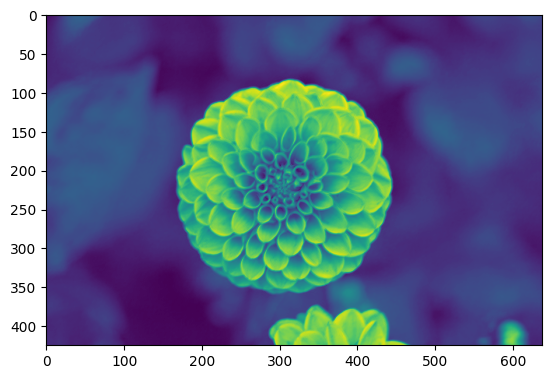

In [24]:
# Creating the model using the Keras Sequential API
model = Sequential()
model.add(Convolution2D(1,    # number of filter layers
                        (3,    # y dimension of kernel (we're going for a 3x3 kernel)
                        3),    # x dimension of kernel
                        input_shape=image.shape))

nice_image_printer(model, image)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
(1, 413, 626, 1)
(413, 626, 1)
(413, 626)


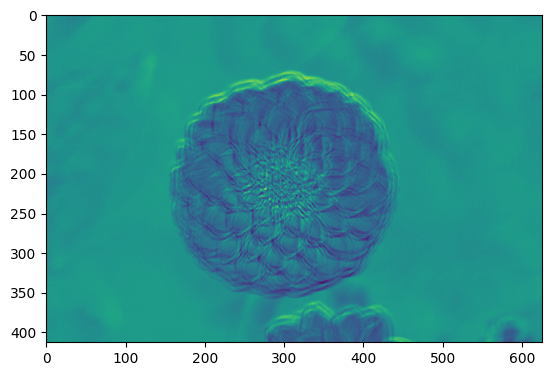

In [25]:
# 15x15 kernel size
model = Sequential()
model.add(Convolution2D(1,    # number of filter layers
                        (15,    # y dimension of kernel (we're going for a 15x15 kernel)
                        15),    # x dimension of kernel
                        input_shape=image.shape))

nice_image_printer(model, image)

### Lets add a relu activation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
(1, 425, 638, 1)
(425, 638, 1)
(425, 638)


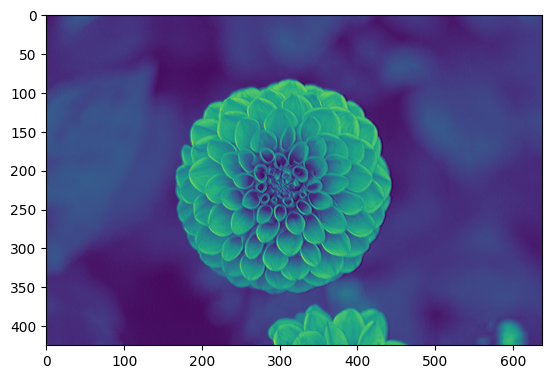

In [26]:
model = Sequential()
model.add(Convolution2D(1,    # number of filter layers
                        (3,    # y dimension of kernel (we're going for a 3x3 kernel)
                        3),    # x dimension of kernel
                        input_shape=image.shape))
# Lets add a new activation layer!
model.add(Activation('relu'))

nice_image_printer(model, image)

### Max Pooling

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
(1, 85, 127, 1)
(85, 127, 1)
(85, 127)


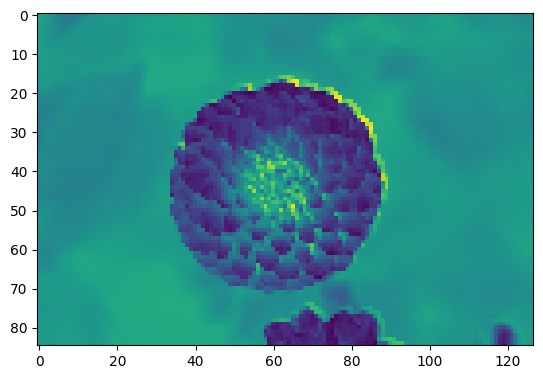

In [27]:
model = Sequential()
model.add(Convolution2D(1,    # number of filter layers
                        (3,    # y dimension of kernel (we're going for a 3x3 kernel)
                        3),    # x dimension of kernel
                        input_shape=image.shape))
# Lets add a new max pooling layer!
model.add(MaxPooling2D(pool_size=(5,5)))

nice_image_printer(model, image)

### Activation then pooling

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
(1, 85, 127, 1)
(85, 127, 1)
(85, 127)


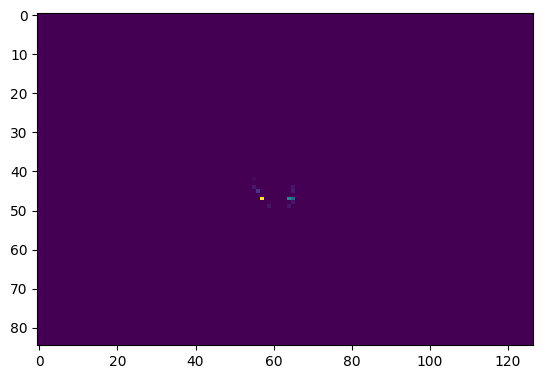

In [28]:
model = Sequential()
model.add(Convolution2D(1,    # number of filter layers
                        (3,    # y dimension of kernel (we're going for a 3x3 kernel)
                        3),    # x dimension of kernel
                        input_shape=image.shape))
# Lets activate then pool!
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(5,5)))

nice_image_printer(model, image)

### Result after the convolutional and pooling stages

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
(1, 46, 70, 1)
(46, 70, 1)
(46, 70)


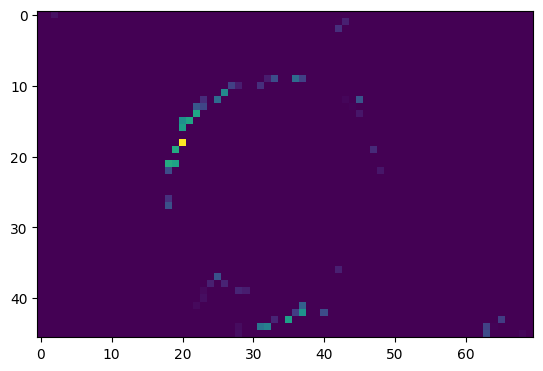

In [29]:
# 1 filter in each conv layer for pretty printing
model = Sequential()
model.add(Convolution2D(1,    # number of filter layers
                        (3,    # y dimension of kernel (we're going for a 3x3 kernel)
                        3),    # x dimension of kernel
                        input_shape=image.shape))
# Lets activate then pool!
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Convolution2D(1,    # number of filter layers
                        (3,    # y dimension of kernel (we're going for a 3x3 kernel)
                        3),    # x dimension of kernel
                        input_shape=image.shape))
# Lets activate then pool!
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

nice_image_printer(model, image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
Output shape after prediction: (1, 213, 320, 16)
Shape after squeezing batch dimension: (213, 320, 16)
Visualizing the first channel out of 16 channels.


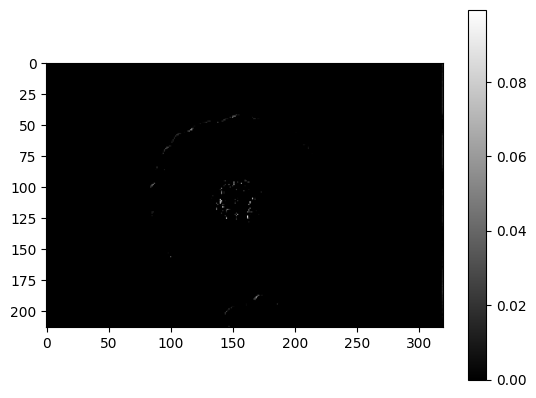

In [30]:
def nice_image_printer(model, image):
    """Prints the output as a 2D feature map for visualization."""
    image_batch = np.expand_dims(image, axis=0)
    conv_image2 = model.predict(image_batch)
    print("Output shape after prediction:", conv_image2.shape)

    # Remove batch dimension
    conv_image2 = np.squeeze(conv_image2, axis=0)
    print("Shape after squeezing batch dimension:", conv_image2.shape)

    # If multiple channels exist, visualize the first channel only
    if len(conv_image2.shape) == 3:  # (H, W, C)
        print("Visualizing the first channel out of", conv_image2.shape[-1], "channels.")
        conv_image2 = conv_image2[:, :, 0]

    # Plot the feature map
    plt.imshow(conv_image2, cmap='gray')
    plt.colorbar()
    plt.show()

# Example model
model = Sequential()
model.add(Convolution2D(16, (3, 3), input_shape=image.shape, padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Test with nice_image_printer
nice_image_printer(model, image)




# CNN for morphological classification of SDSS galaxies <a class="anchor" id="cnn_class"></a>

This section is based on the DL tutorial presented by [Prof. Marc Huertas-Company](https://mhuertascompany.weebly.com) during the [XXX Canary Islands Winter School of Astrophysic](http://research.iac.es/winterschool/2018/). The original notebook can be found [here](https://github.com/mhuertascompany/IAC_XXX_WINTER/tree/master/morphology).

The CNN model is based on the architecture presented by [Domínguez Sánchez+2018](https://ui.adsabs.harvard.edu/abs/2018MNRAS.476.3661D/abstract).

Goal:  separate SDSS galaxies between ellitpicals (early-type) and spirals (late-type) using a CNN architecture. The sample comes from the work of [Nair & Abraham 2010](https://ui.adsabs.harvard.edu/abs/2010ApJS..186..427N/abstract), which contains visual classifications for 14,034 galaxies in the SDSS. In this case we will use a smaller sample of 3,000 galaxies.


Reading the data. The galaxy images are already storaged using npy format.

In [31]:

#output folder
pathsave="/content/drive/MyDrive/lab_DL/"
#if you are using the shared link:
#pathsave="/content/drive/Shareddrives/DL_tutorial/"

maxim=3000 #number of images to read in D, Y vectors


nparams=1

#file to save model weights
model_name=pathsave+"Nair_ES..weights.h5"

## reading

print("Loading D, Y")
D=np.load(pathsave+"image_vector_Sab_"+str(maxim)+".npy") #images
Y=np.load(pathsave+"target_vector_Sab_"+str(maxim)+".npy") #labels (0: eliptical, 1: spiral)


Loading D, Y


Morphology:  spiral


<ipython-input-32-e5c14b797c15>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n=int(np.random.uniform(0,maxim,1))


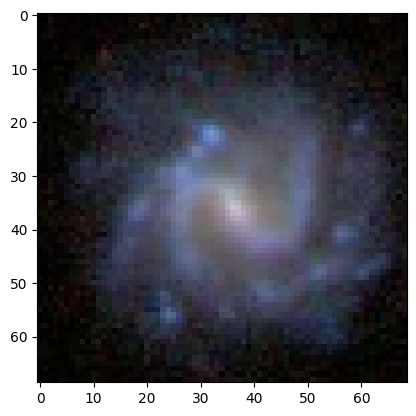

In [32]:
#random image to print
n=int(np.random.uniform(0,maxim,1))

if Y[n]==0:
    mor="elliptical"
else:
    mor="spiral"
print("Morphology: ", mor)
plt.imshow(D[n,:,:,:].astype(int))

Defining the CNN model:

In [33]:
def CNN_Nair(img_channels, img_rows, img_cols):

    # some hyperparamters you can chage
    dropoutpar=0.5
    depth=16 #32
    nb_dense = 64

    # SGD parameters [when using SGD optimizer]
    #lr=0.001   #0.001
    #decay=0
    #momentum=0.9   #0.9
    #nesterov=True

    model=Sequential()
    model.add(Convolution2D(32, 6,6, padding='same',input_shape=(img_rows, img_cols,img_channels)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Convolution2D(64, 5, 5, padding='same'))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(64, 5, 5, padding='same'))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(128, 2, 2, padding='same'))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(128, 3, 3, padding='same'))
    model.add(Activation('relu'))

    model.add(Dropout(0.25))


    model.add(Flatten())
    model.add(Dense(nb_dense, activation='relu'))
    model.add(Dropout(dropoutpar))
    model.add(Dense(1, activation='sigmoid'))
    print("Compilation...")

    # you can change here to SGD optimizer
    #sgd = SGD(lr=lr, decay=decay, momentum=momentum, nesterov=True) #uncomment to use sgd
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    print("... done!")
    print("Model Summary")
    print("===================")
    model.summary()
    return model

Function to train

In [34]:
def train_convnet_Nair(X,Y,ntrain,nval,test_name):


    # train params - hardocded for simplicity - you can change them
    batch_size = 30
    nb_epoch = 50
    data_augmentation = True # if set to True the data will be augmented at every iteration


    ind=random.sample(range(0, ntrain+nval-1), ntrain+nval-1)
    X_train = X[ind[0:ntrain],:,:,:]
    X_val = X[ind[ntrain:ntrain+nval],:,:,:]
    Y_train = Y[ind[0:ntrain]]
    Y_val = Y[ind[ntrain:ntrain+nval]]


    # input image dimensions
    img_rows, img_cols = X_train.shape[1:3]
    img_channels = 3


    ### Right shape for X -- ignore
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols,img_channels)
    X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols,img_channels)


    #Avoid more iterations once convergence
    patience_par=10
    earlystopping = EarlyStopping( monitor='val_loss',patience = patience_par,verbose=0,mode='auto' )
    modelcheckpoint = ModelCheckpoint(test_name+"_best.keras",monitor='val_loss',verbose=0,save_best_only=True)


    #build model
    model=CNN_Nair(img_channels, img_rows, img_cols)




    if not data_augmentation:
        print('Not using data augmentation.')
        history = model.fit(X_train, Y_train,
                            batch_size=batch_size,
                            nb_epoch=nb_epoch,
                            validation_data=(X_val, Y_val),
                            shuffle=True,
                            verbose=verbose, callbacks=[earlystopping, modelcheckpoint])
    else:
        print('Using real-time data augmentation.')

        # this will do preprocessing and realtime data augmentation
        datagen = ImageDataGenerator(
            featurewise_center=False,
            samplewise_center=False,
            featurewise_std_normalization=False,
            samplewise_std_normalization=False,
            zca_whitening=False,
            rotation_range=45,
            width_shift_range=0.05,
            height_shift_range=0.05,
            horizontal_flip=True,
            vertical_flip=True,
            zoom_range=[0.75,1.3])


        datagen.fit(X_train)

        history = model.fit(
                    datagen.flow(X_train, Y_train, batch_size=batch_size),
                    #samples_per_epoch=X_train.shape[0],
                    epochs=nb_epoch,
                    validation_data=(X_val, Y_val),
                    callbacks=[ earlystopping, modelcheckpoint]
                )

        model_loss = pd.DataFrame(model.history.history)
        model_loss.plot()


    print("Saving model...")
    # save weights
    model.save_weights(test_name,overwrite=True)



    return test_name

Function to test

In [35]:
def test_convnet_Nair(X,model_name):

    # input image dimensions
    img_rows, img_cols = X.shape[1:3]
    img_channels = 3
    X = X.reshape(X.shape[0], img_rows, img_cols,img_channels)

    #====== load model & predict=======

    print("Loading weights", model_name)

    model=CNN_Nair(img_channels, img_rows, img_cols)
    model.load_weights(model_name)
    Y_pred_prob = np.ndarray.flatten(model.predict(X))

    Y_pred_class=np.rint(Y_pred_prob)


    return Y_pred_prob, Y_pred_class

Training the model

Training Model
Compilation...
... done!
Model Summary


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 12, 12, 32)          │           3,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 3, 3, 64)            │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 1, 1, 64)            │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 1, 1, 128)           │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 1, 1, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 346,017 (1.32 MB)

 Trainable params: 346,017 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

Using real-time data augmentation.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.5635 - loss: 0.6818 - val_accuracy: 0.5649 - val_loss: 0.6162
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.6832 - loss: 0.5903 - val_accuracy: 0.7448 - val_loss: 0.5212
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.7390 - loss: 0.5252 - val_accuracy: 0.7322 - val_loss: 0.5037
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.7616 - loss: 0.4860 - val_accuracy: 0.7448 - val_loss: 0.5179
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.7662 - loss: 0.4907 - val_accuracy: 0.7950 - val_loss: 0.4648
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.7648 - loss: 0.4922 - val_accuracy: 0.7992 - val_loss: 0.4698
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.7640 - loss: 0.4969 - val_accuracy: 0.8159 - val_loss: 0.4410
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.7727 - loss: 0.4677 - val_accuracy: 0.8201 - val_loss: 0

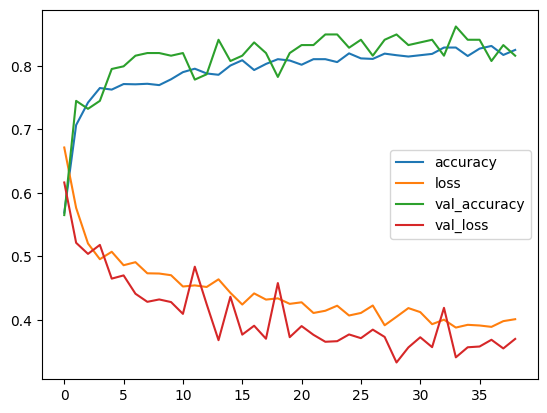

In [36]:
ntrain=int(D.shape[0]*8/10)
nval=int(ntrain/10)


#I apply here some very simple normalization - you can change this too
mu = np.amax(D,axis=(1,2))


for i in range(0,mu.shape[0]):
    D[i,:,:,0] = D[i,:,:,0]/mu[i,0]
    D[i,:,:,1] = D[i,:,:,1]/mu[i,1]
    D[i,:,:,2] = D[i,:,:,2]/mu[i,2]

D, Y, = shuffle(D,Y,random_state=0)  #change order so that we do not use always the same objects to train/test


print("Training Model")
print("====================")
model_name=train_convnet_Nair(D,Y,ntrain,nval,model_name)

Classify test set

In [37]:
npred=D.shape[0]-(ntrain+nval)  #test sample size;
pred_index=ntrain+nval          #test sample start index ;


print("Validating model")
print("====================")
Y_pred_prob, Y_pred_class=test_convnet_Nair(D[pred_index:pred_index+npred,:,:,:],model_name)
Y_test=Y[pred_index:pred_index+npred]

print(Y_pred_class)

Validating model
Loading weights /content/drive/MyDrive/lab_DL/Nair_ES..weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compilation...
... done!
Model Summary


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)                   │ (None, 12, 12, 32)          │           3,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 3, 3, 64)            │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 1, 1, 64)            │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 1, 1, 128)           │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 1, 1, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 346,017 (1.32 MB)

 Trainable params: 346,017 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
[0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1.
 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0.
 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0.
 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.
 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0.
 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0.
 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1.
 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 0

Plotting the confusion matrix

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    print(cm)

    fig, ax = plt.subplots(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 17)
    plt.yticks(tick_marks, classes, fontsize = 17)

    #fmt = '.2f' if normalize else 'd'
    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%d"%  (cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize = 16)

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 18)
    plt.xlabel('Predicted label',fontsize = 18)
    #plt.close()




[[150  12]
 [ 48 150]]
Normalized confusion matrix
[[93.  7.]
 [24. 76.]]


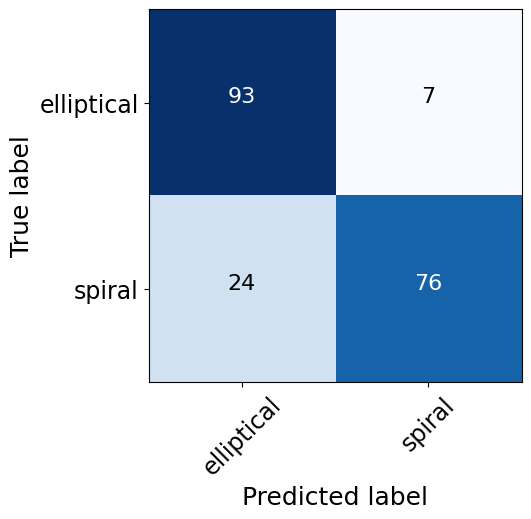

In [39]:
cnf_matrix = confusion_matrix(Y_test, Y_pred_class, labels=[0,1])
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,['elliptical','spiral'])

Plotting some accuracy plots

Global Accuracy: 0.8333333333333334


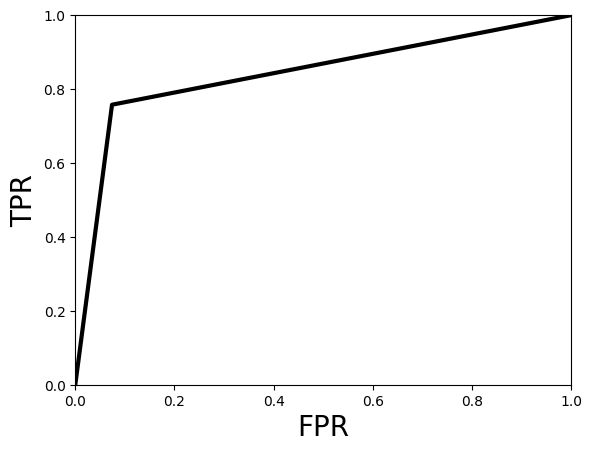

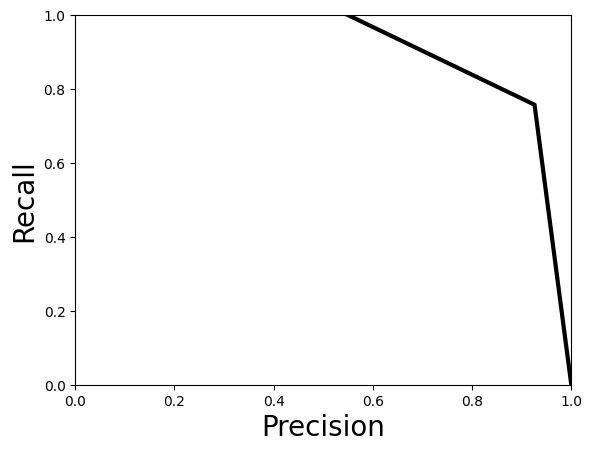

In [40]:
#global accuracy

print("Global Accuracy:", accuracy_score(Y_test, Y_pred_class))

# ROC curve (False positive rate vs. True positive rate)
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_class)

#plot ROC
plt.xlabel("FPR", fontsize=20)
plt.ylabel("TPR", fontsize=20)
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot(fpr,tpr,linewidth=3,color='black')
plt.show()


# ROC curve (False positive rate vs. True positive rate)
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred_class)

#plot ROC
plt.xlabel("Precision", fontsize=20)
plt.ylabel("Recall", fontsize=20)
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot(precision,recall,linewidth=3,color='black')
plt.show()

Let's visualize some of the wrong classifications.

<ipython-input-41-e9c868a23ddd>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n=int(np.random.uniform(0,bad2[0].shape,1))


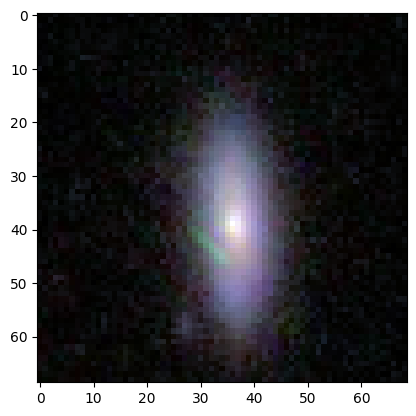

In [41]:
# objects classifed as early-types by the CNN but visually classifed as late-types
bad = np.where((Y_pred_prob<0.5)&(Y_test==1))

# objects classifed as late-types by the CNN but visually classifed as early-types
bad2 = np.where((Y_pred_prob>0.5)&(Y_test==0))


# show random image
n=int(np.random.uniform(0,bad2[0].shape,1))

plt.imshow(D[pred_index+bad2[0][0],:,:,:])

Homework: create your own version of the model and check out the results:

Training Custom Model


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compilation...
... done!
Model Summary


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 12, 12, 32)          │           3,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 3, 3, 64)            │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 1, 1, 64)            │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 1, 1, 128)           │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 1, 1, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 346,017 (1.32 MB)

 Trainable params: 346,017 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

Using real-time data augmentation.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.5557 - loss: 0.6862 - val_accuracy: 0.5607 - val_loss: 0.6718
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.5635 - loss: 0.6692 - val_accuracy: 0.5607 - val_loss: 0.5590
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.6766 - loss: 0.5737 - val_accuracy: 0.7908 - val_loss: 0.5052
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7348 - loss: 0.5514 - val_accuracy: 0.7908 - val_loss: 0.4578
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.7403 - loss: 0.5170 - val_accuracy: 0.8243 - val_loss: 0.4261
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.7808 - loss: 0.4932 - val_accuracy: 0.8159 - val_loss: 0.4145
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.7711 - loss: 0.4842 - val_accuracy: 0.8159 - val_loss: 0.3946
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.7727 - loss: 0.4962 - val_accuracy: 0.8117 - val_loss: 0

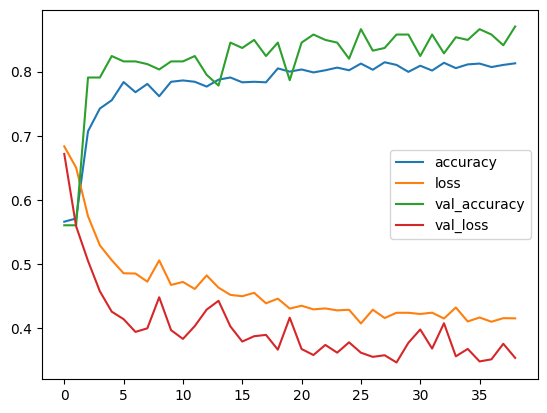

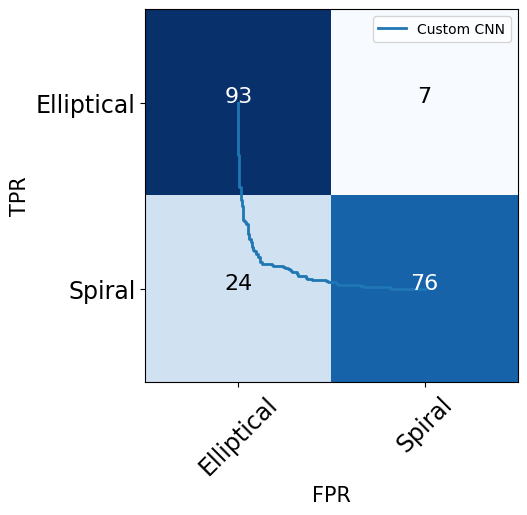

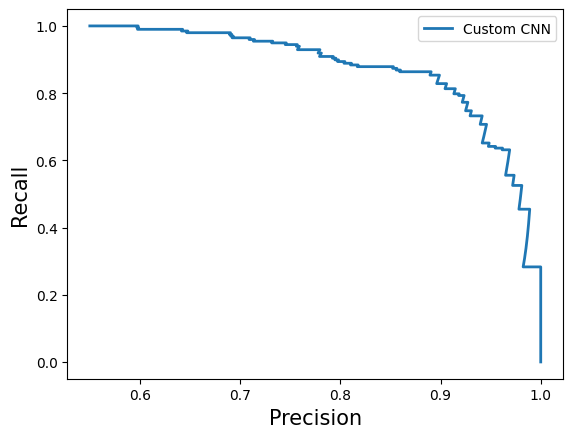

In [42]:
from tensorflow.keras.layers import BatchNormalization

def custom_CNN(img_channels, img_rows, img_cols):
    """
    Custom CNN Model for Galaxy Classification
    """
    dropoutpar = 0.4  # Reduced dropout
    nb_dense = 128    # Increased dense layer size

    model = Sequential()

    # Convolutional Block 1
    model.add(Convolution2D(32, (3, 3), padding='same', input_shape=(img_rows, img_cols, img_channels)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropoutpar))

    # Convolutional Block 2
    model.add(Convolution2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropoutpar))

    # Convolutional Block 3
    model.add(Convolution2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropoutpar))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(nb_dense, activation='relu'))
    model.add(Dropout(dropoutpar))
    model.add(Dense(1, activation='sigmoid'))

    # Compile Model
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )

    print("Custom Model Summary")
    model.summary()

    return model

# Training using the custom model
print("Training Custom Model")
print("====================")
model_name = train_convnet_Nair(D, Y, ntrain, nval, model_name)

# Confusion Matrix
cnf_matrix = confusion_matrix(Y_test, Y_pred_class, labels=[0, 1])
plot_confusion_matrix(cnf_matrix, ['Elliptical', 'Spiral'])

# ROC Curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)
plt.plot(fpr, tpr, linewidth=2, label='Custom CNN')
plt.xlabel("FPR", fontsize=15)
plt.ylabel("TPR", fontsize=15)
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred_prob)
plt.plot(precision, recall, linewidth=2, label='Custom CNN')
plt.xlabel("Precision", fontsize=15)
plt.ylabel("Recall", fontsize=15)
plt.legend()
plt.show()


# RNN for time series analysis <a class="anchor" id="rnn"></a>

This section is adapted from [this notebook](https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb) from the book [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/). I strongly recommend this book for beginners.

The goal is to use RNNs to forecast time series (simulated).

### Generate the data set

The function below creates a sample of time series with a given batch size and a given size. We use it to generate a sample of time series for training, validation, and testing

In [43]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [44]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [45]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [46]:
X_test.shape, y_test.shape

((1000, 50, 1), (1000, 1))

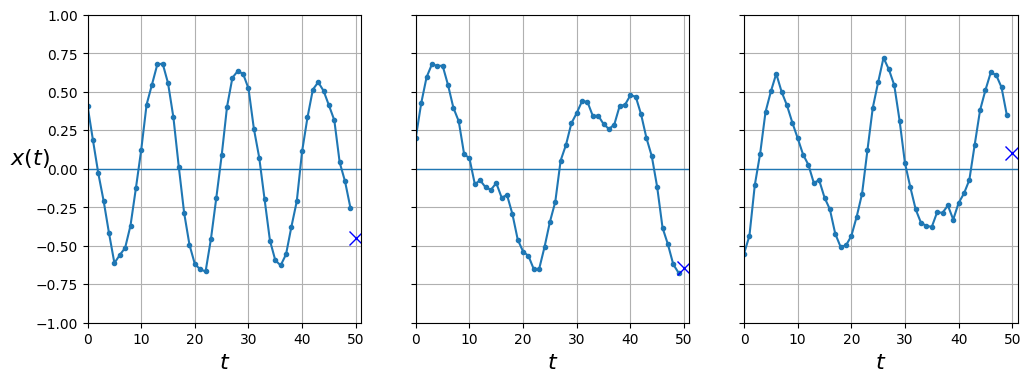

In [47]:
# Let's plot some of the generated time series
# This function can be used to plot predictions of the time series.

def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))

plt.show()

Now we will predict the next observation in the the time series using a simple RNN architecture.

In [49]:
rnn_model = Sequential([
    SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    SimpleRNN(20, return_sequences=True),
    SimpleRNN(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
rnn_model.compile(loss="mse", optimizer=optimizer)

#homework: add an earlystopping callback as in the CNN example
history = rnn_model.fit(X_train, y_train, epochs=40,
                    validation_data=(X_valid, y_valid))

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 0.0340 - val_loss: 0.0038
Epoch 2/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 3/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 4/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 5/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 6/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 7/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 8/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 9/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 10/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 11/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 12/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/st

<Axes: >

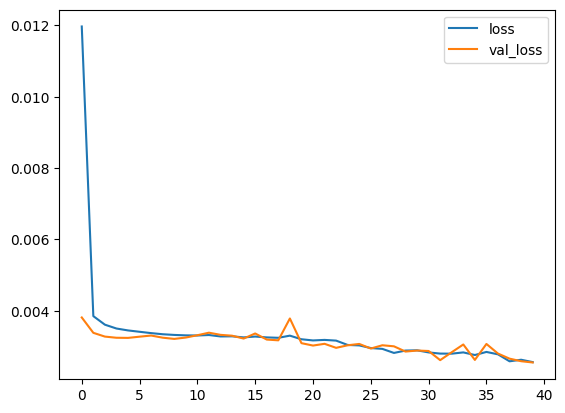

In [50]:
model_loss = pd.DataFrame(rnn_model.history.history)
model_loss.plot()

In [51]:
rnn_model.evaluate(X_valid, y_valid)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024


0.0025527183897793293

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


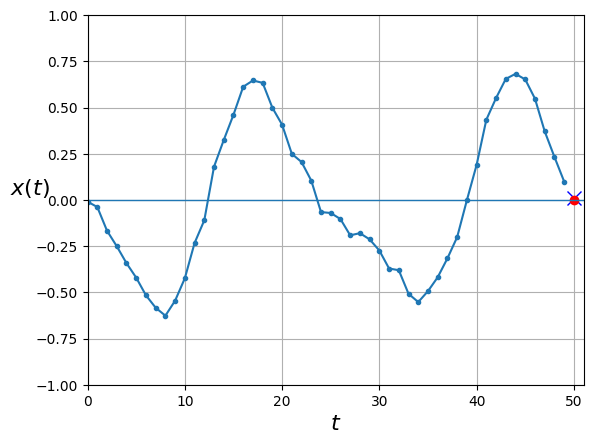

In [52]:
#predicting next point of the time series
y_pred = rnn_model.predict(X_test)
plot_series(X_test[0, :, 0], y_test[0, 0], y_pred[0, 0])
plt.show()

Forcasting several steps ahead

In [53]:
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = rnn_model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [54]:
Y_pred.shape


(1, 10, 1)

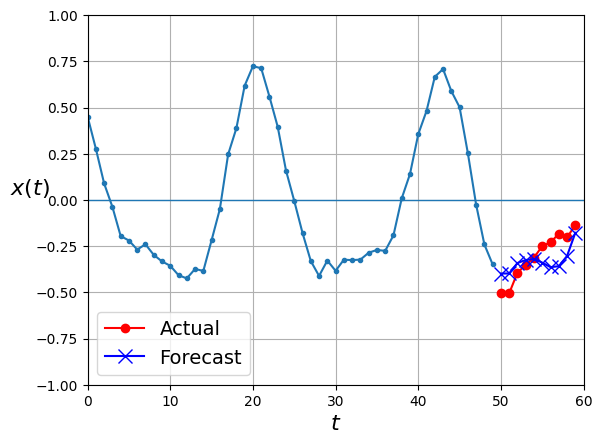

In [55]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()


In [56]:
# Define the early stopping callback
early_stopping_cb = EarlyStopping(
    monitor="val_loss",  # Monitor validation loss
    patience=10,         # Stop training after 10 epochs of no improvement
    restore_best_weights=True  # Restore model weights from the best epoch
)

# Train the RNN model with the early stopping callback
history = rnn_model.fit(
    X_train, y_train,
    epochs=40,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping_cb]  # Include the callback
)


Epoch 1/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 2/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 3/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 4/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 5/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 6/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 7/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 8/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 9/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 10/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 11/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 12/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 

<Axes: >

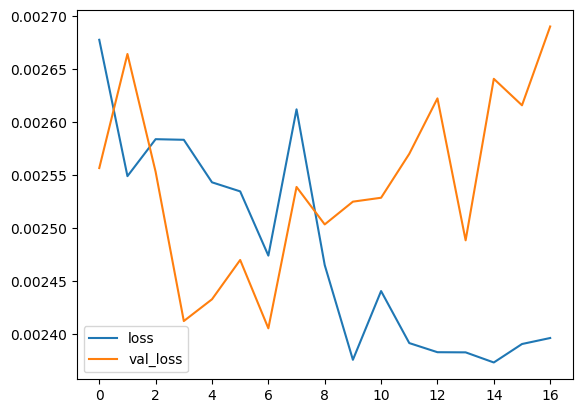

In [57]:
model_loss = pd.DataFrame(rnn_model.history.history)
model_loss.plot()

In [58]:
rnn_model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0023


0.0024051708169281483

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


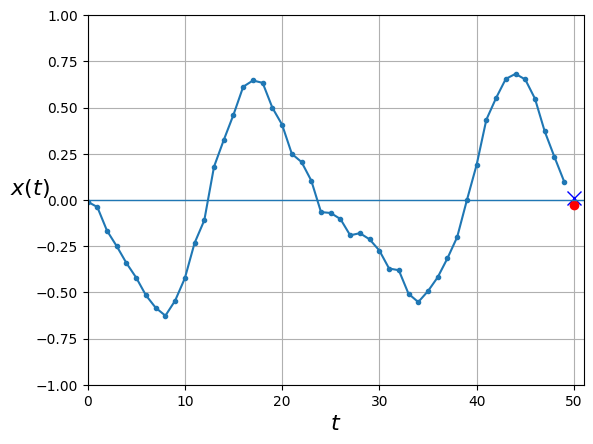

In [59]:
#predicting next point of the time series
y_pred = rnn_model.predict(X_test)
plot_series(X_test[0, :, 0], y_test[0, 0], y_pred[0, 0])
plt.show()

# Autoencoders <a class="anchor" id="ae"></a>

In this section we will use Autoencoders for anomaly detection. We will simulate time series as in the previous example.  We will train a recurrent autoencoder (RAE) to create reconstructions of the data using a training set composed only by "normal" time series. Then we will generate a testing set composed by normal time series as well as anomalies. Finally, we will use the reconstruction error as an anomaly score to define a sample of anomalies.

In [60]:
#generating normal time series

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [61]:
n_steps = 50
series = generate_time_series(10000, n_steps)

X_train = series[:9000]
X_test = series[9000:]

In [62]:
# generating anonalies

def generate_anomalous_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.9* np.cos((time - offsets1) * (freq1 * 20 + 10))  #  modified wave 1
    series += 0.3 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [63]:
n_steps = 50
series_anom = generate_anomalous_time_series(500, n_steps) # we will include 500 anomalies in the testing sample

X_anom = series_anom
X_test_new = np.concatenate((X_test,X_anom))


In [64]:
X_train.shape

(9000, 50, 1)

In [65]:
X_test_new.shape

(1500, 50, 1)

In [66]:
#defining the recurrent autoencoder model


recurrent_encoder = Sequential([
    LSTM(20, return_sequences=True, input_shape=[X_train.shape[1],X_train.shape[2]]),
    LSTM(10)
])
recurrent_decoder = Sequential([
    RepeatVector(X_train.shape[1], input_shape=[10]),
    LSTM(20, return_sequences=True),
    TimeDistributed(Dense(X_train.shape[1], activation="linear"))
])
rae_model = Sequential([recurrent_encoder, recurrent_decoder])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/repeat_vector.py:29: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [67]:
rae_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
rae_model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_12 (Sequential)           │ (None, 10)                  │           3,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_13 (Sequential)           │ (None, 50, 50)              │           3,530 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,530 (25.51 KB)

 Trainable params: 6,530 (25.51 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
#training with normal data

history = rae_model.fit(
    X_train,
    X_train,
    epochs=300,
    batch_size=62,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=10, mode="min")
    ],
)

Epoch 1/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 0.1450 - val_loss: 0.1415
Epoch 2/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.1413 - val_loss: 0.1409
Epoch 3/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1406 - val_loss: 0.1394
Epoch 4/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1411 - val_loss: 0.1380
Epoch 5/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1355 - val_loss: 0.1371
Epoch 6/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1315 - val_loss: 0.1268
Epoch 7/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1256 - val_loss: 0.1202
Epoch 8/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1179 - val_loss: 0.1043
Epoch 9/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1022 - val_loss: 0.0926
Epoch 10/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0905 - val_loss: 0.0919
Epoch 11/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0867 - val_loss: 0.0836
Epoch 12/300
117/117 ━━━━━━━━━

<Axes: >

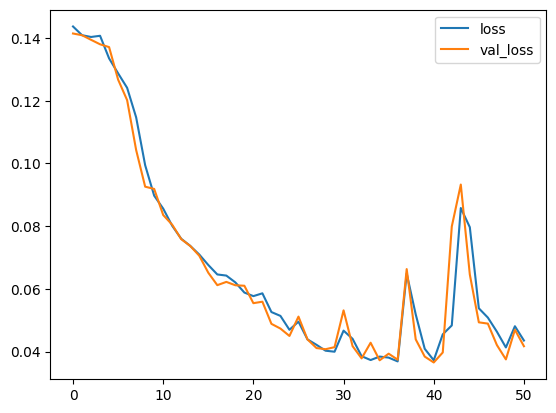

In [69]:
#plotting the rae learning curve
model_loss = pd.DataFrame(rae_model.history.history)
model_loss.plot()

In [70]:
# predicting (or reconstructing) the data
prediction_train = rae_model.predict(X_train)
prediction_test = rae_model.predict(X_test_new)


282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


plotting original time series and the reconstructed time series training set


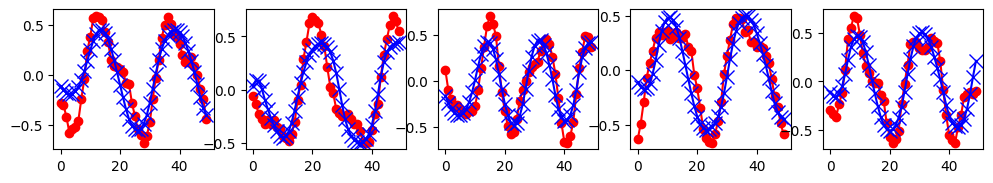

In [71]:
#plotting some reconstructions for the training set

i = 50
k=0
fignum = 5
plt.figure(figsize=(12, 4))
print("plotting original time series and the reconstructed time series training set")
for num in range(i,i+fignum):
    plt.subplot(2, fignum, k+1)
    plt.plot(np.arange(0, n_steps), X_train[num, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(0,n_steps), prediction_train[num, :, 0], "bx-", label="Forecast", markersize=10)
    k += 1


plotting original time series and the reconstructed time series testing set


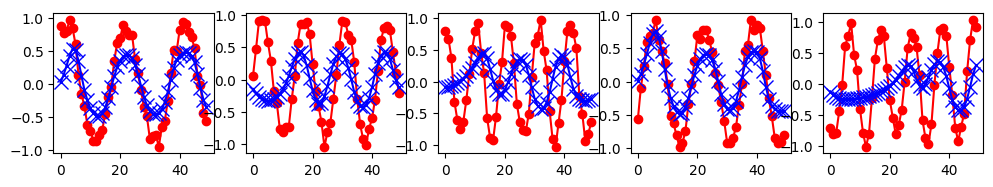

In [72]:
#plotting some reconstructions for the testing set (selecting the set of anomalies)

i = 1060
k=0
fignum = 5
plt.figure(figsize=(12, 4))
print("plotting original time series and the reconstructed time series testing set")
for num in range(i,i+fignum):
    plt.subplot(2, fignum, k+1)
    plt.plot(np.arange(0, n_steps), X_test_new[num, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(0,n_steps), prediction_test[num, :, 0], "bx-", label="Forecast", markersize=10)
    k += 1

In [73]:
#computing reconstruction errors (using mae)

train_rec_err = np.sum(np.abs(X_train[:,:,0]-prediction_train[:,:,0]),axis=1)/50.0
test_rec_err = np.sum(np.abs(X_test_new[:,:,0]-prediction_test[:,:,0]),axis=1)/50.0


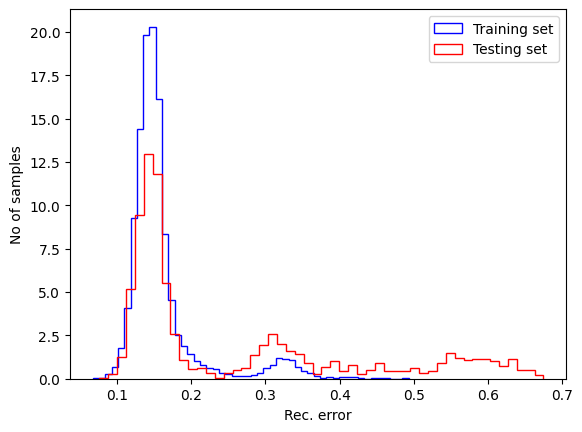

In [74]:
plt.hist(train_rec_err , bins=50,color='b',density=True,histtype='step',label='Training set')
plt.hist(test_rec_err , bins=50,color='r',density=True,histtype='step',label='Testing set')

plt.xlabel("Rec. error")
plt.ylabel("No of samples")
plt.legend()
plt.show()

We can use the reconstruction error (test_mae_loss) as an anomaly score. Sources with larger reconstruction error are probably anomalies.

In this example, the simulated anomalies correspond to the last 500 elements of the vector X_test_new. They have consistently larger reconstruction errors than the rest of the test set.

Text(0, 0.5, 'reconstruction error')

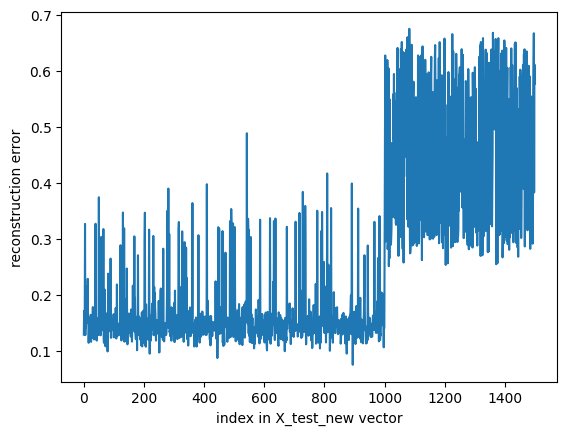

In [75]:
plt.plot(np.arange(0,len(test_rec_err )),test_rec_err )
plt.xlabel('index in X_test_new vector')
plt.ylabel('reconstruction error')

Homework: define your own AE architecture  (you can use RNNs, CNNs, or whatever you want)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_15 (Sequential)           │ (None, 20)                  │          13,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_16 (Sequential)           │ (None, 50, 1)               │          13,457 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,593 (103.88 KB)

 Trainable params: 26,593 (103.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.1412 - val_loss: 0.1356
Epoch 2/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1322 - val_loss: 0.1121
Epoch 3/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1074 - val_loss: 0.0823
Epoch 4/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0787 - val_loss: 0.0609
Epoch 5/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0586 - val_loss: 0.0462
Epoch 6/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0443 - val_loss: 0.0377
Epoch 7/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0362 - val_loss: 0.0318
Epoch 8/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0323 - val_loss: 0.0294
Epoch 9/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0308 - val_loss: 0.0282
Epoch 10/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0287 - val_loss: 0.0285
Epoch 11/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0276 - val_loss: 0.0256
Epoch 12/300
117/117 ━━━━━━━━━

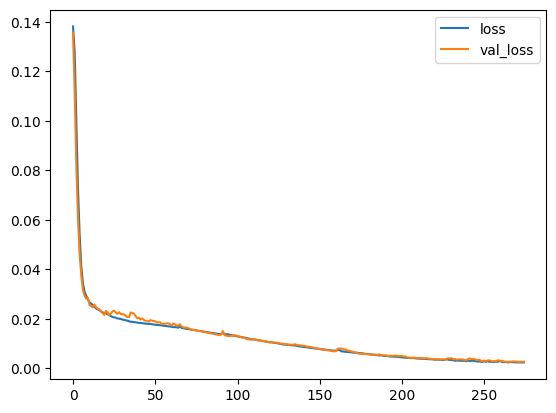

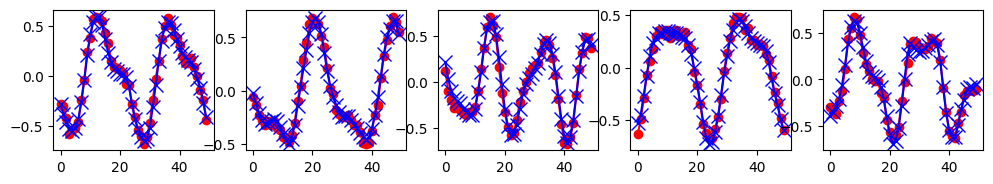

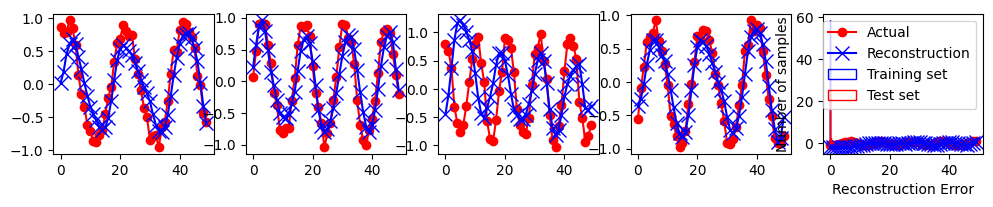

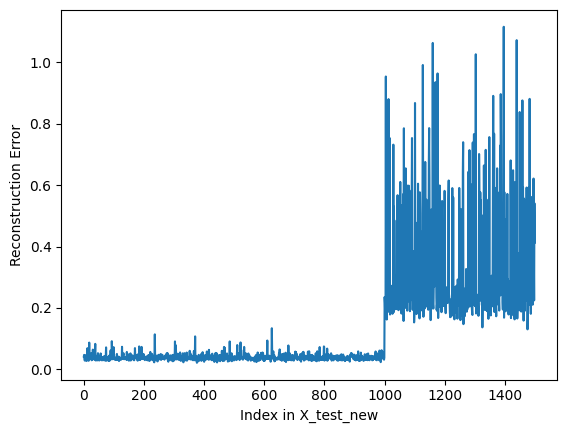

In [77]:
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.models import Sequential

def create_cnn_lstm_autoencoder(input_shape):
    # Encoder: Convolutional layers followed by LSTM
    encoder = Sequential([
        Conv1D(32, kernel_size=3, activation="relu", padding="same", input_shape=input_shape),
        Conv1D(64, kernel_size=3, activation="relu", padding="same"),
        LSTM(20, return_sequences=False)  # Output latent representation
    ])

    # Decoder: RepeatVector followed by LSTM and Conv1DTranspose for reconstruction
    decoder = Sequential([
        RepeatVector(input_shape[0]),  # Repeat for time steps
        LSTM(20, return_sequences=True),
        Conv1DTranspose(64, kernel_size=3, activation="relu", padding="same"),
        Conv1DTranspose(32, kernel_size=3, activation="relu", padding="same"),
        Conv1D(1, kernel_size=3, activation="linear", padding="same")  # Output reconstructed series
    ])

    # Full Autoencoder
    autoencoder = Sequential([encoder, decoder])

    # Compile the model
    autoencoder.compile(optimizer="adam", loss="mse")

    return autoencoder

# Define the input shape based on the training data
input_shape = (X_train.shape[1], X_train.shape[2])  # (n_steps, 1)

# Create the CNN + LSTM Autoencoder model
cnn_lstm_ae_model = create_cnn_lstm_autoencoder(input_shape)
cnn_lstm_ae_model.summary()

# Training the CNN + LSTM Autoencoder
history = cnn_lstm_ae_model.fit(
    X_train,
    X_train,
    epochs=300,
    batch_size=62,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=10, mode="min")
    ],
)

# Plotting the loss curves
model_loss = pd.DataFrame(cnn_lstm_ae_model.history.history)
model_loss.plot()

# Predicting (reconstructing) the data
prediction_train_cnn_lstm = cnn_lstm_ae_model.predict(X_train)
prediction_test_cnn_lstm = cnn_lstm_ae_model.predict(X_test_new)

# Plotting reconstruction for the training set
i = 50
k=0
fignum = 5
plt.figure(figsize=(12, 4))
print("Plotting original time series and the reconstructed time series (training set)")
for num in range(i, i + fignum):
    plt.subplot(2, fignum, k+1)
    plt.plot(np.arange(0, n_steps), X_train[num, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(0, n_steps), prediction_train_cnn_lstm[num, :, 0], "bx-", label="Reconstruction", markersize=10)
    k += 1

# Plotting reconstruction for the test set (with anomalies)
i = 1060
k=0
fignum = 5
plt.figure(figsize=(12, 4))
print("Plotting original time series and the reconstructed time series (test set with anomalies)")
for num in range(i, i + fignum):
    plt.subplot(2, fignum, k+1)
    plt.plot(np.arange(0, n_steps), X_test_new[num, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(0, n_steps), prediction_test_cnn_lstm[num, :, 0], "bx-", label="Reconstruction", markersize=10)
    k += 1

# Compute reconstruction errors (using MAE)
train_rec_err_cnn_lstm = np.mean(np.abs(X_train[:,:,0] - prediction_train_cnn_lstm[:,:,0]), axis=1)
test_rec_err_cnn_lstm = np.mean(np.abs(X_test_new[:,:,0] - prediction_test_cnn_lstm[:,:,0]), axis=1)

# Plot the histograms of reconstruction errors
plt.hist(train_rec_err_cnn_lstm, bins=50, color='b', density=True, histtype='step', label='Training set')
plt.hist(test_rec_err_cnn_lstm, bins=50, color='r', density=True, histtype='step', label='Test set')
plt.xlabel("Reconstruction Error")
plt.ylabel("Number of samples")
plt.legend()
plt.show()

# Plot reconstruction error for the test set
plt.plot(np.arange(0, len(test_rec_err_cnn_lstm)), test_rec_err_cnn_lstm)
plt.xlabel('Index in X_test_new')
plt.ylabel('Reconstruction Error')
plt.show()


# Transformers

Homework: follow the tutorial from this link: https://huggingface.co/blog/time-series-transformers (also here: https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/time-series-transformers.ipynb#scrollTo=d93a3f41)

This tutorial uses the Transformers python library (https://huggingface.co/docs/transformers/index), written by Hugging Face (https://huggingface.com)